In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
https = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
url = requests.get(https).text

soup = BeautifulSoup(url, 'lxml')
#print(soup.prettify())



### Observations From Original Version

We observed that more detailed data was conducted on data from 1996 and onwards. We will separate those dataframes to more easily analyze.

In [3]:
#we create a list of all useable links, all_links
raw_links = soup.find_all('a')
all_links = []
for link in raw_links:
    if (link.get('href') not in raw_links):
        all_links.append(link.get('href'))

#we create a list of all links to detailed data, csv_links
csv_detailed_links = []        
for link in all_links:
    if((link[-6:-1] == 'csv.g') and link.startswith('StormEvents_details')):
        csv_detailed_links.append(link)

#we create a list of all links to fatalaty data, csv_links
csv_fatalities_links = []        
for link in all_links:
    if((link[-6:-1] == 'csv.g') and link.startswith('StormEvents_fatalities')):
        csv_fatalities_links.append(link)
        
#we create a list of all links to location data, csv_links
csv_location_links = []        
for link in all_links:
    if((link[-6:-1] == 'csv.g') and link.startswith('StormEvents_locations')):
        csv_location_links.append(link)        

In [4]:
any(ext in csv_detailed_links for ext in [str(x) for x in range(1996,2019)])
# [x for x in range(10).astype(str)]

False

In [5]:
det_df_after95 = pd.DataFrame()
for i in [link for link in csv_detailed_links if any(ext in link for ext in [str(x) for x in range(1996,2019)])]:
    det_df_after95 = pd.concat([det_df_after95,pd.read_csv(https + i, index_col = 'EVENT_ID')])

#we'll run these later    
# fatalities_df = pd.DataFrame()
# for i in csv_fatalities_links:
#     fatalities_df = pd.concat([fatalities_df,pd.read_csv(https + i)])
    
# location_df = pd.DataFrame()
# for i in csv_location_links:
#     location_df = pd.concat([location_df,pd.read_csv(https + i)])

/Users/MacBookPro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/MacBookPro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/MacBookPro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
det_df_after95.head()

In [ ]:
det_def_after95.shape

In [ ]:
#CHECKS TO MAKE SURE THERE ARE NO DUPLICATES. IT'S ALL GOOD!!!!

# det_df_after95.sort_index()

# idx = pd.Index(det_df_after95)
# idx.duplicated()

# from collections import Counter

# indexes = idx.duplicated()

# print(Counter(indexes).keys()) # equals to list(set(words))
# print(Counter(indexes).values()) # counts the elements' frequency

In [ ]:
#removing any column that has more than 60% of data as NA
#first get a list of boolean columns that have more than 60% of data still intact
test = det_df_after95.isnull().sum() < .6*det_df_after95.shape[0]

In [ ]:
# returns list of column names that have 60%
columns = [test.index[i] for i in range(len(test)) if test[i]]
columns

In [ ]:
detailed_df_remove_na = det_df_after95[columns]

In [ ]:
detailed_df_remove_na.info()

In [ ]:
detailed_df_remove_na.head()

In [ ]:
#prints the number of unique values in each column
[print(column, len(detailed_df_remove_na[column].unique())) for column in detailed_df_remove_na.columns]

In [ ]:
#what I'm thinking now is that there is so much data already... 1.5million+ rows, it might be okay to just remove rows with na
detailed_df_remove_na.shape

In [ ]:
detailed_df_remove_na.isna().sum()

In [ ]:
#removes rows that contain any na
# det_df = detailed_df_remove_na.dropna()

#testing data without dropping
det_df = detailed_df_remove_na.copy()

In [ ]:
# Check how many rows are removed
# det_df.info()

Let's see which columns need cleaning...
Referencing: https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.docx

EPISODE_ID: float --> object/int 
CZ_FIPS: float --> object

BEGIN_DATE_TIME: object --> datetime
CZ_TIMEZONE
END_DATE_TIME: object --> datetime

**DAMAGE_PROPERTY: object --> int/float
DAMAGE_CROPS: object --> int/float

In [ ]:
#created function to clean strings ending in "K" and "M"
#input dataframe and column name
def clean_nums(df, column):
    for i in range(len(df[column])):
        if type(df.loc[i, column]) == float:
            pass
        elif df.loc[i, column] == 'K':
            df.set_value(i, column, 1000)
        elif df.loc[i,column].endswith('K'):
            df.loc[i, column] = df.loc[i, column].replace("K", "")
            df.set_value(i, column, (float(df.loc[i, column]) * 1000))
        elif df.loc[i,column].endswith('M'):
            df.loc[i, column] = df.loc[i, column].replace("M", "")
            df.set_value(i, column, (float(df.loc[i, column]) * 1000000))
        else:
            df.set_value(i, column, float(df.loc[i,column]))
    df[column] = df[column].astype(float)

# BELOW is the testcase
#--------------------------------------------
# test_case = det_df.head(2000)
# test_case = test_case.reset_index(drop=True)
# print(test_case['DAMAGE_CROPS'])
# clean_nums(test_case, 'DAMAGE_CROPS')
# print(test_case['DAMAGE_CROPS'])

In [ ]:
df_new = det_df[['DAMAGE_PROPERTY']]
part1 = df_new[df_new['DAMAGE_PROPERTY'].map(lambda x: x[-1] == 'K')]['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1]) * 1000)
#part2 = df_new[df_new['DAMAGE_PROPERTY'].map(lambda x: x[-1] == 'M')]['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1]) * 1000000)
#part3 = df_new[df_new['DAMAGE_PROPERTY'].map(lambda x: x[-1] == 'B')]['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1]) * 1000000000)
#part4 = df_new[df_new['DAMAGE_PROPERTY'].map(lambda x: x[-1] != 'K' and x[-1] != 'M' and x[-1] != 'B')]['DAMAGE_PROPERTY']

In [ ]:
#df_new[df_new['DAMAGE_PROPERTY'].map(lambda x: x[-1] == 'K')]['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1]) * 1000)
df_new['DAMAGE_PROPERTY'].map(lambda x: x[:-1] if (x[-1] == 'K'))

In [ ]:
ends = [x[-1] for x in df_new['DAMAGE_PROPERTY'].unique() if type(x)== str]
pd.Series(ends).value_counts()
# print(set(ends))

In [ ]:
part_all = pd.concat([part1, part2, part3, part4])
det_df_clean = det_df.copy()
# det_df.sort_index(inplace=True)
# part_all.sort_index(inplace=True)
det_df_clean['DAMAGE_PROPERTY_CLEAN'] = part_all.astype(float)
# det_df_clean.append(part_all)

In [ ]:
det_df_clean.sort_index()
det_df_clean.head() 
det_df_clean.info()

In [ ]:
# det_def.head()
print(len(det_df))
print(len(part1)+len(part2)+len(part3)+len(part4))


In [ ]:
det_df_clean['DAMAGE_PROPERTY_CLEAN'].head()

In [ ]:
df_new2['DAMAGE_CROPS'].unique()[2]

In [ ]:
df_new2 = det_df[['DAMAGE_CROPS']]

ends = [x[-1] for x in df_new2['DAMAGE_CROPS'].unique() if type(x)== str]
pd.Series(ends).value_counts()
print(set(ends))

#part12 = df_new2[df_new2['DAMAGE_CROPS'].map(lambda x: x[-1] == 'K')]['DAMAGE_CROPS'].map(lambda x: float(x[:-1]) * 1000)
#part22 = df_new2[df_new2['DAMAGE_CROPS'].map(lambda x: x[-1] == 'M')]['DAMAGE_CROPS'].map(lambda x: float(x[:-1]) * 1000000)
#part32 = df_new2[df_new2['DAMAGE_CROPS'].map(lambda x: x[-1] == 'B')]['DAMAGE_CROPS'].map(lambda x: float(x[:-1]) * 1000000000)
#part42 = df_new2[df_new2['DAMAGE_CROPS'].map(lambda x: x[-1] != 'K' and x[-1] != 'M' and x[-1] != 'B')]['DAMAGE_CROPS']

In [ ]:
# det_df_clean = det_df.reset_index(drop=True)
# clean_nums(det_df_clean, 'DAMAGE_PROPERTY')
# clean_nums(det_df_clean, 'DAMAGE_CROPS')

#Think this took an hour to run....

In [ ]:
det_df_clean.to_csv("US_Storm_Events_noNA_clean.csv")

##### Diving into tableau to see current data, I discovered that data <= 1995 were less comprehensive than <=1996
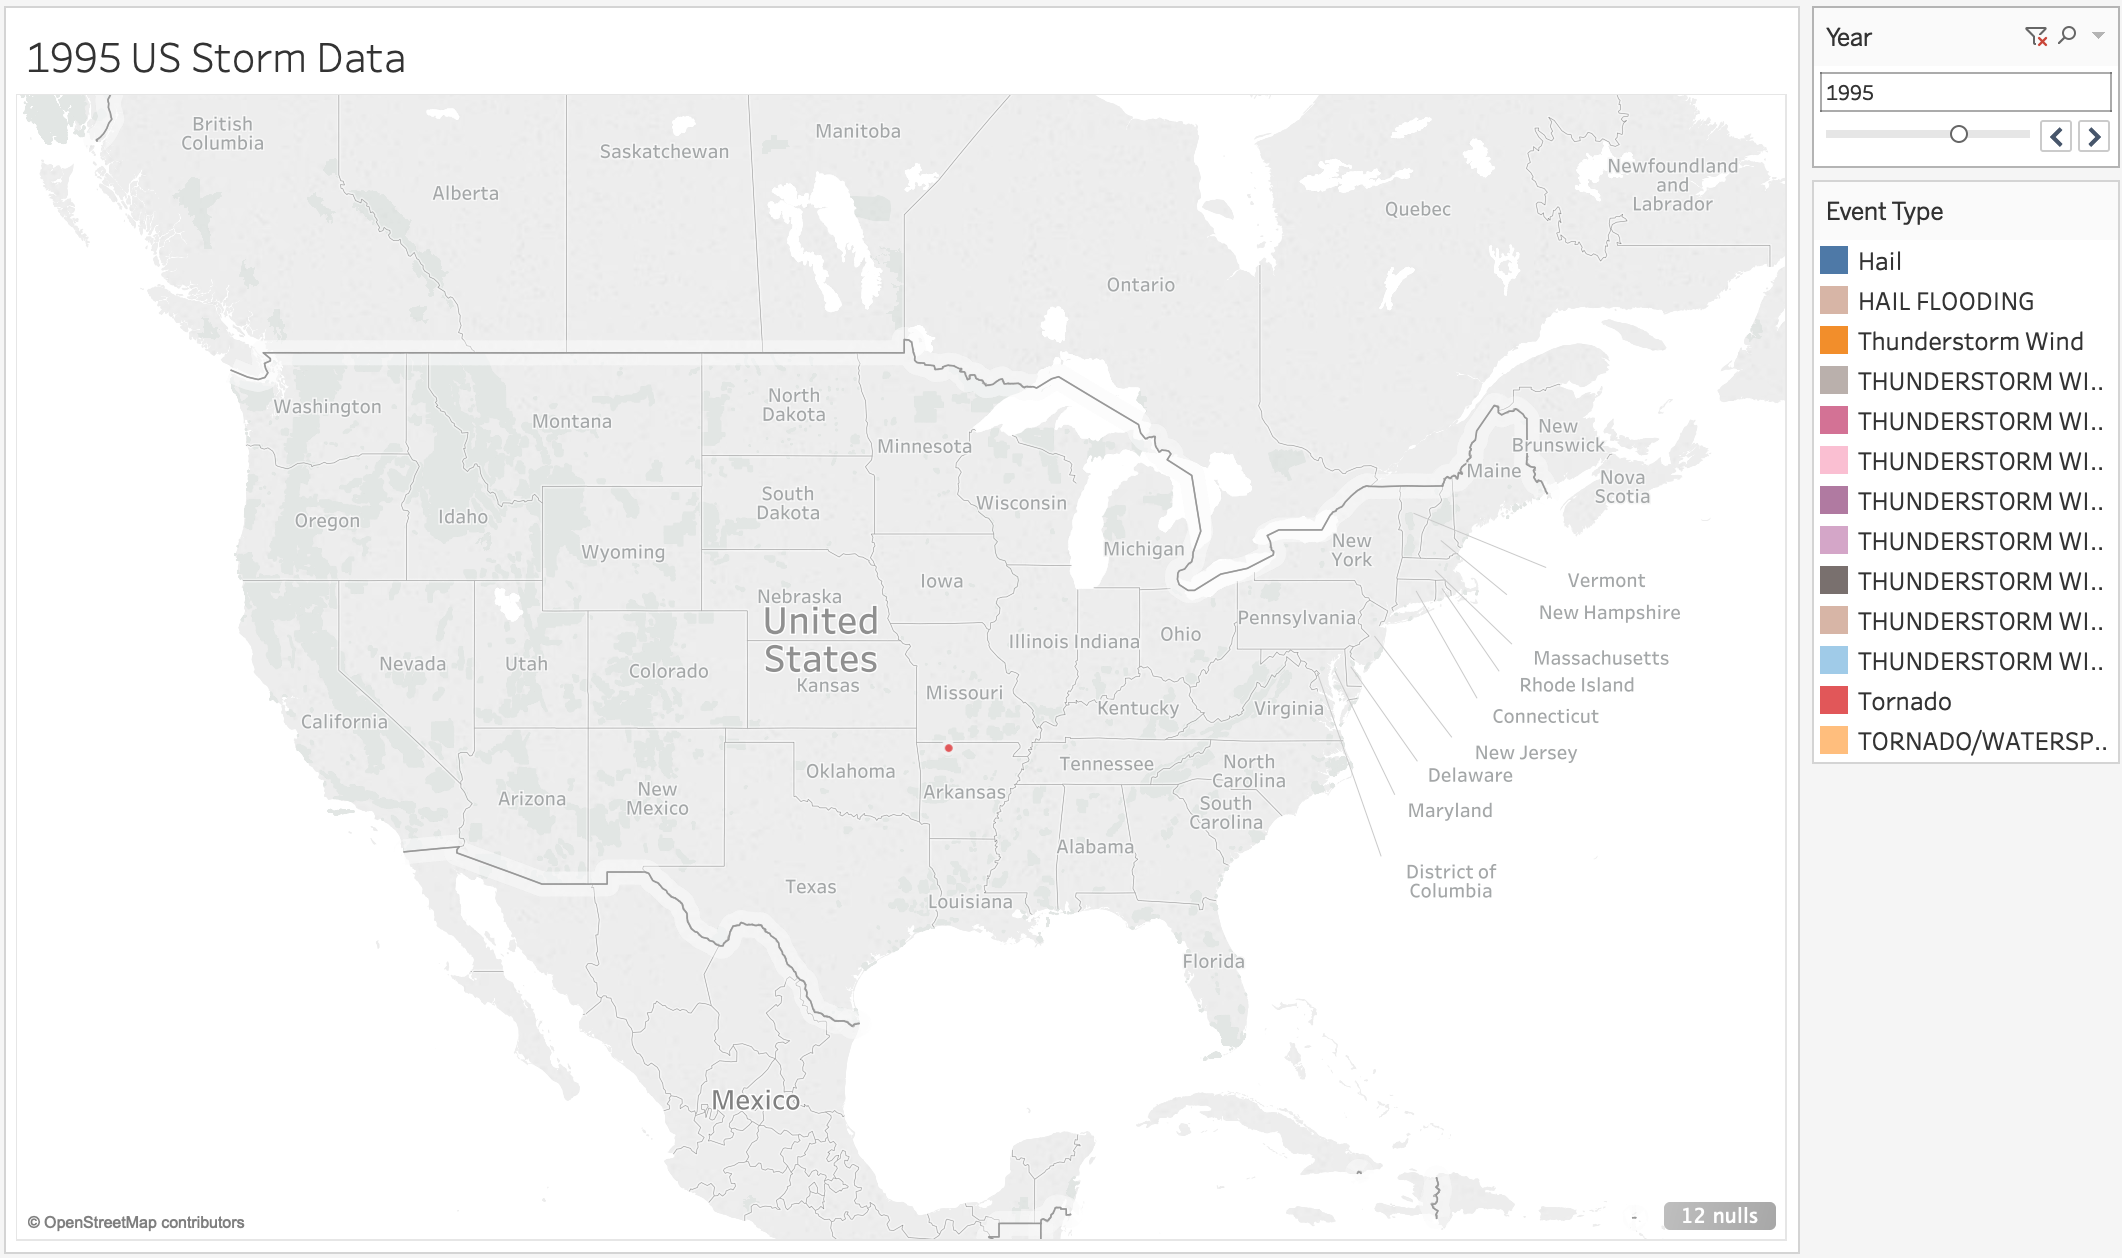

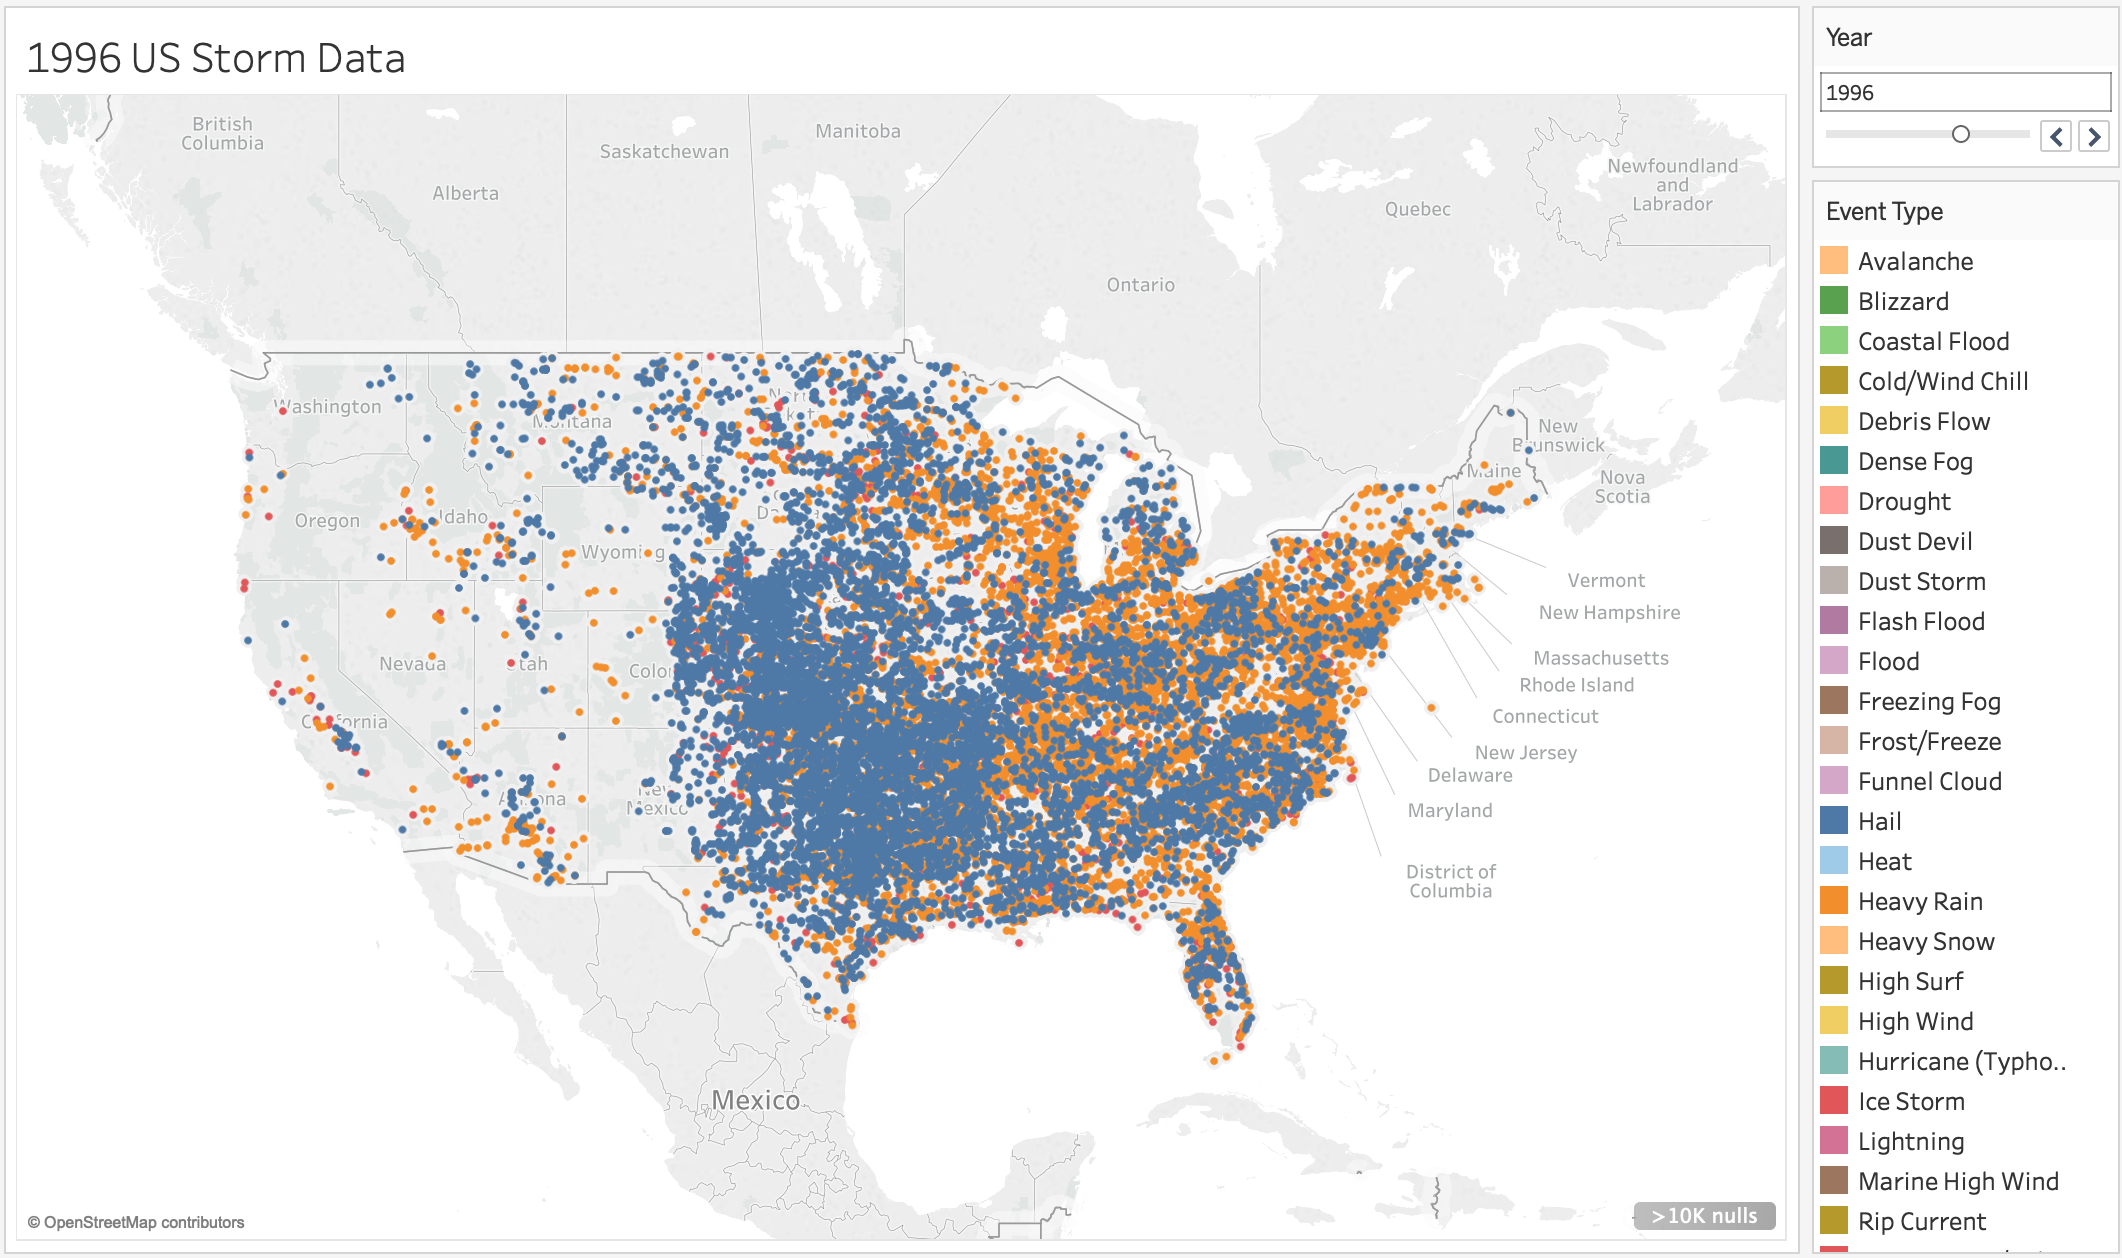